In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import nctoolkit as nc

from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

1 file was created by nctoolkit in prior or current sessions. Consider running deep_clean!
nctoolkit is using Climate Data Operators version 2.0.5


In [2]:
nc.deep_clean()

## Setup

In [3]:
# NOTE: can't use glob for MOZART because there are multiple h0 files in each month's directory
date_range = pd.date_range(start="2014-09", end="2017-04", freq="1M")
mozart_paths = []
for month in date_range:
    yyyy, mm, _ = str(month).split("-")
    mozart_paths.append(
        f"../1_transport/intermediates/MOZART/output/BasisFnsUpdated/{yyyy}{mm}/"
        f"BasisFnsUpdated.mz4.h0.{yyyy}-{mm}-01-03600.nc"
    )
    

geoschem_spec_conc_glob = (
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "GEOSChem.SpeciesConc.*_0000z.nc4"
)
geoschem_level_edge_glob = (
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "GEOSChem.LevelEdgeDiags.*_0000z.nc4"
)

In [4]:
# 1-degree grid configuration
EARTH_SURFACE_AREA = 5.100644719e14 # (m^2)
target_grid = xe.util.grid_global(1, 1, cf=True)
target_grid

<xarray.Dataset>
Dimensions:     (bound: 2, lon: 360, lat: 180)
Coordinates:
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bound
Data variables:
    lon_bounds  (bound, lon) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
    lat_bounds  (bound, lat) int64 -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89 90

In [5]:
# produce 1-degree grid cell areas
# read in a single GEOS Chem ouput file, regrid AREA variable with nctoolkit, and update areas
ds_area = nc.open_data(
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "GEOSChem.SpeciesConc.20140901_0000z.nc4"
)
ds_area.subset(variables = "AREA")
ds_area.to_latlon(lon = [-179.5, 179.5], lat = [-89.5, 89.5], res = [1, 1], method="con")
ds_area.cell_area(join=False)
target_grid_area = ds_area.to_xarray()["cell_area"]
target_grid_area

<xarray.DataArray 'cell_area' (lat: 180, lon: 360)>
array([[1.078908e+08, 1.078908e+08, 1.078908e+08, ..., 1.078908e+08,
        1.078908e+08, 1.078908e+08],
       [3.236394e+08, 3.236394e+08, 3.236394e+08, ..., 3.236394e+08,
        3.236394e+08, 3.236394e+08],
       [5.392896e+08, 5.392896e+08, 5.392896e+08, ..., 5.392896e+08,
        5.392896e+08, 5.392896e+08],
       ...,
       [5.392896e+08, 5.392896e+08, 5.392896e+08, ..., 5.392896e+08,
        5.392896e+08, 5.392896e+08],
       [3.236394e+08, 3.236394e+08, 3.236394e+08, ..., 3.236394e+08,
        3.236394e+08, 3.236394e+08],
       [1.078908e+08, 1.078908e+08, 1.078908e+08, ..., 1.078908e+08,
        1.078908e+08, 1.078908e+08]])
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    standard_name:  area
    long_name:      area of grid cell
    units:          m^2

In [6]:
def get_mozart_pressure_edges(ds):
    # compute pressure edges in units hPA; equation: https://www2.acom.ucar.edu/gcm/mozart-4
    return (ds["P0"] * ds["hyai"] + ds["PS"] * ds["hybi"]) * 0.01


def compute_pressure_weights(ds, level_name: str):
    surface_pressure = ds[level_name].max(dim="ilev")
    weights = abs(ds[level_name].diff("ilev").rename(ilev="lev") / surface_pressure)
    # levels will take the value of the minuend’s ilev coordinate, instead we need to update
    # to the dataset's level coordinate
    weights["lev"] = ds["lev"]
    return weights


def compute_xco2(ds, mole_frac_name: str, weights_name: str):
    # compute pressure-weighted average over vertical column in units ppm
    return (ds[mole_frac_name] * ds[weights_name]).sum(dim="lev") * 1e6


In [ ]:
# NOTE: run the above cells, then run one of the sections below

## Compute pressure weighted average at first timestep for both models and map the difference

In [7]:
with xr.open_dataset(
    "../1_transport/intermediates/MOZART/output/BasisFnsUpdated/201409/"
    "BasisFnsUpdated.mz4.h0.2014-09-01-03600.nc",
    decode_times=False,
) as ds:
    ds = ds.isel(time=0)
    ds["pressure_edge"] = get_mozart_pressure_edges(ds)
    ds["pressure_weights"] = compute_pressure_weights(ds, "pressure_edge")

    ds_mozart = ds[["CO2_VMR_avrg", "pressure_weights"]]
    ds_mozart = xe.Regridder(ds_mozart, target_grid, method="conservative")(ds_mozart)

    da_mozart_xco2 = compute_xco2(ds_mozart, "CO2_VMR_avrg", "pressure_weights")


with xr.open_mfdataset(
    [
        "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
        "GEOSChem.LevelEdgeDiags.20140901_0000z.nc4",
        "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
        "GEOSChem.SpeciesConc.20140901_0000z.nc4",
    ]
) as ds:
    ds = ds.isel(time=0)
    ds["pressure_weights"] = compute_pressure_weights(ds, "Met_PEDGE")

    ds_geoschem = ds[["SpeciesConc_CO2", "pressure_weights"]]
    ds_geoschem = xe.Regridder(ds_geoschem, target_grid, method="conservative")(ds_geoschem)

    da_geoschem_xco2 = compute_xco2(ds_geoschem, "SpeciesConc_CO2", "pressure_weights")


da_xco2_diff_t0 = da_geoschem_xco2 - da_mozart_xco2


/home/jj829/miniconda3/envs/nctoolkit_demo/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
/home/jj829/miniconda3/envs/nctoolkit_demo/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
/home/jj829/miniconda3/envs/nctoolkit_demo/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]


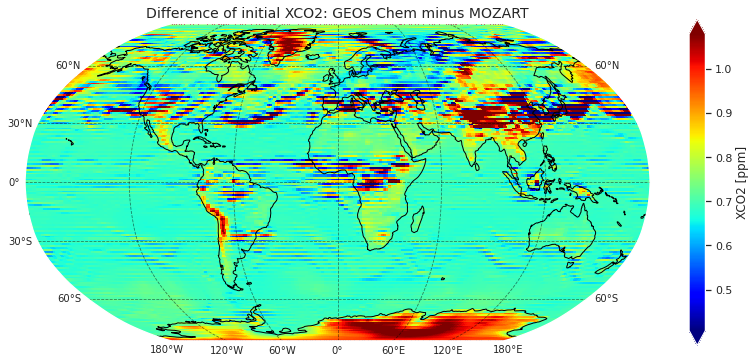

In [8]:
def prep_axes(ax):
    ax.set_global()
    ax.coastlines()
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        linewidth=0.8,
        color="black",
        alpha=0.5,
        linestyle="--",
        draw_labels=True,
    )
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER


PROJ = ccrs.Robinson()
fig, ax = plt.subplots(figsize=(14, 6), subplot_kw={"projection": PROJ})
xr.plot.imshow(
    darray=da_xco2_diff_t0,
    transform=ccrs.PlateCarree(),
    ax=ax,
    cmap="jet",
    robust=True,
    cbar_kwargs={"label": "XCO2 [ppm]"},
)
prep_axes(ax)
ax.set_title("Difference of initial XCO2: GEOS Chem minus MOZART", fontsize=14)
fig.savefig(f"../figures/map_xco2_diff_initial.png", dpi=200);


## Suface analyses

### Hovmoller diagrams

In [7]:
## produce surface level datasets of monthly longitudinal averages (5 min compute time)

with xr.open_dataset(mozart_paths[0], decode_times=False) as ds:
    # precompute mozart grid weights
    regridder_mozart = xe.Regridder(ds[["CO2_VMR_avrg"]], target_grid, "conservative")


def prep_mozart(ds):
    ds["time"] = pd.to_datetime(ds.date.values, format="%Y%m%d") + pd.to_timedelta(
        ds.datesec.values, unit="seconds"
    )
    # surface level is the LAST element along the lev dimension
    ds_co2 = ds[["CO2_VMR_avrg"]].isel(lev=-1)
    return regridder_mozart(ds_co2).mean(dim="lon")


with xr.open_mfdataset(
    mozart_paths,
    preprocess=prep_mozart,
    chunks={"time": 1000},
    parallel=True,
    decode_times=False,
) as ds:
    ds = ds.where(ds["time"] < pd.to_datetime("2017-04-01"), drop=True)
    da_mozart_co2_hov = ds["CO2_VMR_avrg"].resample(time="1M").mean().drop("lev") * 1e6


with xr.open_dataset(
    "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
    "GEOSChem.SpeciesConc.20140901_0000z.nc4"
) as ds:
    # precompute geos chem grid weights
    regridder_geoschem = xe.Regridder(ds[["SpeciesConc_CO2"]], target_grid, "conservative")


def prep_geoschem(ds):
    # surface level is the FIRST element along the lev dimension
    ds_co2 = ds[["SpeciesConc_CO2"]].isel(lev=0)
    return regridder_geoschem(ds_co2).mean(dim="lon")


with xr.open_mfdataset(
    geoschem_spec_conc_glob, preprocess=prep_geoschem, chunks={"time": 1000}, parallel=True
) as ds:
    ds = ds.where(ds["time"] < pd.to_datetime("2017-04-01"), drop=True)
    da_geoschem_co2_hov = ds["SpeciesConc_CO2"].resample(time="1M").mean().drop("lev") * 1e6

da_surface_hov_diff = da_geoschem_co2_hov - da_mozart_co2_hov


/home/jj829/miniconda3/envs/nctoolkit_demo/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
/home/jj829/miniconda3/envs/nctoolkit_demo/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]


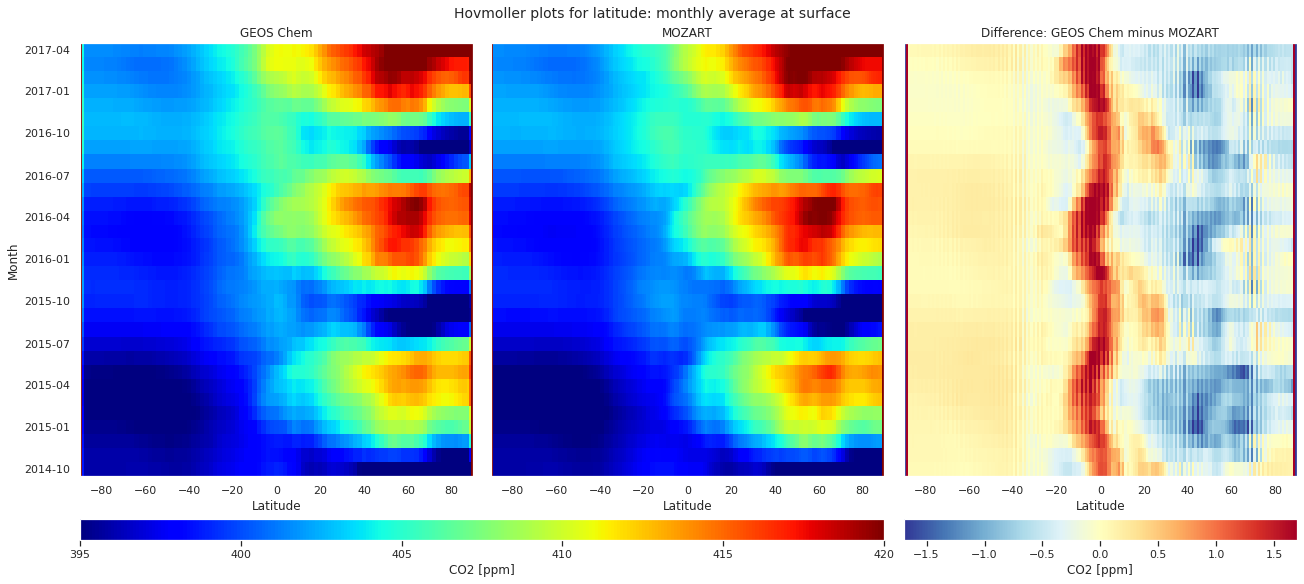

In [11]:
fig = plt.figure(figsize=(18, 8), constrained_layout=True)

gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 0.05])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
main_cbar_ax = fig.add_subplot(gs[1, :2])
diff_cbar_ax = fig.add_subplot(gs[1, 2])

vmin, vmax = 395, 420
sub_geoschem = da_geoschem_co2_hov.plot(
    ax=ax1, vmin=vmin, vmax=vmax, cmap="jet", add_colorbar=False
)
sub_mozart = da_mozart_co2_hov.plot(
    ax=ax2, vmin=vmin, vmax=vmax, cmap="jet", add_colorbar=False
)
fig.colorbar(
    sub_geoschem, cax=main_cbar_ax, orientation="horizontal", label="CO2 [ppm]"
)

sub_diff = da_surface_hov_diff.plot(ax=ax3, robust=True, cmap="RdYlBu_r", add_colorbar=False)
fig.colorbar(sub_diff, cax=diff_cbar_ax, orientation="horizontal", label="CO2 [ppm]")

ax1.set_title("GEOS Chem", fontsize=12)
ax1.set_ylabel("Month", fontsize=12)
ax2.set_title("MOZART", fontsize=12)
ax2.set_ylabel(None)
plt.setp(ax2.get_yticklabels(), visible=False)
ax3.set_title("Difference: GEOS Chem minus MOZART", fontsize=12)
ax3.set_ylabel(None)
plt.setp(ax3.get_yticklabels(), visible=False)
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("Latitude", fontsize=12)

fig.suptitle("Hovmoller plots for latitude: monthly average at surface", fontsize=14)
fig.savefig(f"../figures/hovmoller_lat_surface.png", dpi=200);


### Time series of global (area weighted) averages

In [7]:
## produce time series of monthly global surface averages

with xr.open_dataset(mozart_paths[0], decode_times=False) as ds:
    # precompute mozart grid box areas
    ds_grid = nc.from_xarray(ds["CO2_VMR_avrg"].isel(time=0))
    ds_grid.subset(time=0)
    ds_grid.cell_area(join=False)
    da_mozart_gridbox_area = ds_grid.to_xarray()["cell_area"]


def prep_mozart(ds):
    ds["time"] = pd.to_datetime(ds.date.values, format="%Y%m%d") + pd.to_timedelta(
        ds.datesec.values, unit="seconds"
    )
    # surface level is the LAST element along the lev dimension
    surface_weights = ds["CO2_VMR_avrg"].isel(lev=-1) * da_mozart_gridbox_area
    return surface_weights.sum(dim=["lon", "lat"]) / EARTH_SURFACE_AREA


with xr.open_mfdataset(
    mozart_paths,
    preprocess=prep_mozart,
    parallel=True,
    decode_times=False,
) as ds:
    ds = ds.where(ds["time"] < pd.to_datetime("2017-04-01"), drop=True)
    da_mozart_surface_avg = ds.resample(time="1M").mean() * 1e6


def prep_geoschem(ds):
    # surface level is the FIRST element along the lev dimension
    surface_weights = ds["SpeciesConc_CO2"].isel(lev=0) * ds["AREA"]
    return surface_weights.sum(dim=["lon", "lat"]) / EARTH_SURFACE_AREA


with xr.open_mfdataset(geoschem_spec_conc_glob, preprocess=prep_geoschem, parallel=True) as ds:
    ds = ds.where(ds["time"] < pd.to_datetime("2017-04-01"), drop=True)
    da_geoschem_surface_avg = ds.resample(time="1M").mean() * 1e6

da_surface_avg_diff = da_geoschem_surface_avg - da_mozart_surface_avg


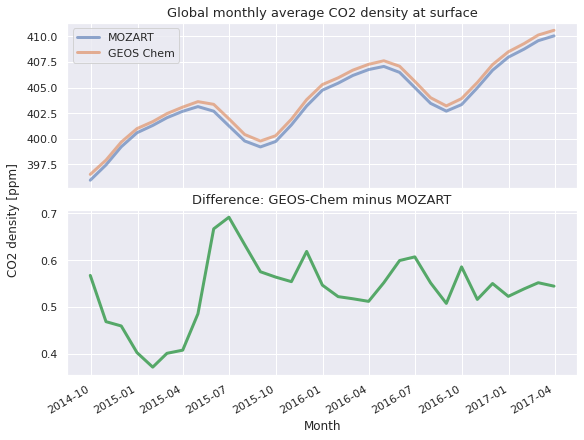

In [10]:
fig, axes = plt.subplots(2, 1, figsize=[8, 6], sharex=True, constrained_layout=True)

da_mozart_surface_avg.plot(ax=axes[0], linewidth=3, alpha=0.6, label="MOZART")
da_geoschem_surface_avg.plot(ax=axes[0], linewidth=3, alpha=0.6, label="GEOS Chem")
axes[0].set_title("Global monthly average CO2 density at surface", fontsize=13)
axes[0].set_xlabel(None)
axes[0].legend()

da_surface_avg_diff.plot(ax=axes[1], linewidth=3, color="#55a868")
axes[1].set_title("Difference: GEOS-Chem minus MOZART", fontsize=13)
axes[1].set_xlabel("Month", fontsize=12)

fig.supylabel("CO2 density [ppm]", fontsize=12)
fig.savefig("../figures/timeseries_global_monthly_average_surface.png", dpi=200);

## Vertical column analyses

### Hovmoller diagrams

In [8]:
## produce xco2 datasets of monthly longitudinal averages (10 min runtime)

with xr.open_dataset(mozart_paths[0], decode_times=False) as ds:
    # precompute mozart grid weights
    ds["pressure_edge"] = get_mozart_pressure_edges(ds)
    ds["pressure_weights"] = compute_pressure_weights(ds, "pressure_edge")
    ds_mozart = ds[["CO2_VMR_avrg", "pressure_weights"]]
    regridder_mozart = xe.Regridder(ds_mozart, target_grid, "conservative")


def prep_mozart(ds):
    ds["time"] = pd.to_datetime(ds.date.values, format="%Y%m%d") + pd.to_timedelta(
        ds.datesec.values, unit="seconds"
    )
    # ds = ds.resample(time="1M").mean()
    ds["pressure_edge"] = get_mozart_pressure_edges(ds)
    ds["pressure_weights"] = compute_pressure_weights(ds, "pressure_edge")
    ds_mozart = regridder_mozart(ds[["CO2_VMR_avrg", "pressure_weights"]])
    da_mozart_xco2 = compute_xco2(ds_mozart, "CO2_VMR_avrg", "pressure_weights")
    return da_mozart_xco2.mean(dim="lon")


with xr.open_mfdataset(
    mozart_paths,
    preprocess=prep_mozart,
    chunks={"time": 1000},
    parallel=True,
    decode_times=False,
) as da:
    da = da.where(da["time"] < pd.to_datetime("2017-04-01"), drop=True)
    da_mozart_xco2_hov = da.resample(time="1M").mean()
    # da_mozart_xco2_hov = da.where(da["time"] < pd.to_datetime("2017-04-01"), drop=True)


with xr.open_mfdataset(
    [
        "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
        "GEOSChem.LevelEdgeDiags.20140901_0000z.nc4",
        "../1_transport/intermediates/GEOS_Chem/runs/run.v12.3.2.base/output/"
        "GEOSChem.SpeciesConc.20140901_0000z.nc4",
    ]
) as ds:
    # precompute geos chem grid weights
    ds["pressure_weights"] = compute_pressure_weights(ds, "Met_PEDGE")
    regridder_geoschem = xe.Regridder(
        ds[["SpeciesConc_CO2", "pressure_weights"]], target_grid, "conservative"
    )


def prep_geoschem_lev(ds):
    return ds["Met_PEDGE"]


da_geoschem_lev = xr.open_mfdataset(
    geoschem_level_edge_glob, preprocess=prep_geoschem_lev, chunks={"time": 1000}, parallel=True
)


def prep_geoschem(ds):
    return ds[["SpeciesConc_CO2"]]


with xr.open_mfdataset(
    geoschem_spec_conc_glob, preprocess=prep_geoschem, chunks={"time": 1000}, parallel=True
) as ds:
    ds["Met_PEDGE"] = da_geoschem_lev["Met_PEDGE"]
    # NOTE: different order of operations...
    ds = (
        ds.where(ds["time"] < pd.to_datetime("2017-04-01"), drop=True)
        .resample(time="1M")
        .mean()
    )
    ds["pressure_weights"] = compute_pressure_weights(ds, "Met_PEDGE")
    ds_geoschem = regridder_geoschem(ds[["SpeciesConc_CO2", "pressure_weights"]])
    da_geoschem_xco2 = compute_xco2(ds_geoschem, "SpeciesConc_CO2", "pressure_weights")
    da_geoschem_xco2_hov = da_geoschem_xco2.mean(dim="lon")

da_xco2_hov_diff = da_geoschem_xco2_hov - da_mozart_xco2_hov


/home/jj829/miniconda3/envs/nctoolkit_demo/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
/home/jj829/miniconda3/envs/nctoolkit_demo/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]


In [9]:
fig = plt.figure(figsize=(18, 8), constrained_layout=True)

gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 0.05])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
main_cbar_ax = fig.add_subplot(gs[1, :2])
diff_cbar_ax = fig.add_subplot(gs[1, 2])

# vmin, vmax = 395, 420
# sub_geoschem = da_geoschem_xco2_hov.plot(
#     ax=ax1, vmin=vmin, vmax=vmax, cmap="jet", add_colorbar=False
# )
# sub_mozart = da_mozart_xco2_hov.plot(
#     ax=ax2, vmin=vmin, vmax=vmax, cmap="jet", add_colorbar=False
# )
sub_geoschem = da_geoschem_xco2_hov.plot(
    ax=ax1, robust=True, cmap="jet", add_colorbar=False
)
sub_mozart = da_mozart_xco2_hov.plot(
    ax=ax2, robust=True, cmap="jet", add_colorbar=False
)
fig.colorbar(
    sub_geoschem, cax=main_cbar_ax, orientation="horizontal", label="CO2 [ppm]"
)

sub_diff = da_xco2_hov_diff.plot(ax=ax3, robust=True, cmap="RdYlBu_r", add_colorbar=False)
fig.colorbar(sub_diff, cax=diff_cbar_ax, orientation="horizontal", label="CO2 [ppm]")

ax1.set_title("GEOS Chem", fontsize=12)
ax1.set_ylabel("Month", fontsize=12)
ax2.set_title("MOZART", fontsize=12)
ax2.set_ylabel(None)
plt.setp(ax2.get_yticklabels(), visible=False)
ax3.set_title("Difference: GEOS Chem minus MOZART", fontsize=12)
ax3.set_ylabel(None)
plt.setp(ax3.get_yticklabels(), visible=False)
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("Latitude", fontsize=12)

fig.suptitle(
    "Hovmoller plots for latitude: monthly pressure-weighted vertical average (XCO2)", 
    fontsize=14
)
fig.savefig(f"../figures/hovmoller_lat_xco2.png", dpi=200);

### Time series of global (pressure and area weighted) averages

In [7]:
## produce time series of monthly global surface averages

with xr.open_dataset(mozart_paths[0], decode_times=False) as ds:
    # precompute mozart grid box areas
    ds_grid = nc.from_xarray(ds["CO2_VMR_avrg"].isel(time=0))
    ds_grid.subset(time=0)
    ds_grid.cell_area(join=False)
    da_mozart_gridbox_area = ds_grid.to_xarray()["cell_area"]


def prep_mozart(ds):
    ds["time"] = pd.to_datetime(ds.date.values, format="%Y%m%d") + pd.to_timedelta(
        ds.datesec.values, unit="seconds"
    )
    ds["pressure_edge"] = get_mozart_pressure_edges(ds)
    ds["pressure_weights"] = compute_pressure_weights(ds, "pressure_edge")
    ds_mozart_xco2 = compute_xco2(ds, "CO2_VMR_avrg", "pressure_weights")
    surface_weights = ds_mozart_xco2 * da_mozart_gridbox_area
    return surface_weights.sum(dim=["lon", "lat"]) / EARTH_SURFACE_AREA


with xr.open_mfdataset(
    mozart_paths,
    preprocess=prep_mozart,
    parallel=True,
    decode_times=False,
) as ds:
    ds = ds.where(ds["time"] < pd.to_datetime("2017-04-01"), drop=True)
    da_mozart_xco2_avg = ds.resample(time="1M").mean()


def prep_geoschem_lev(ds):
    return ds["Met_PEDGE"]


with xr.open_mfdataset(
    geoschem_level_edge_glob, preprocess=prep_geoschem_lev, parallel=True
) as da:
    da_geoschem_lev = da.where(da["time"] < pd.to_datetime("2017-04-01"), drop=True)


def prep_geoschem(ds):
    return ds[["SpeciesConc_CO2", "AREA"]]


with xr.open_mfdataset(geoschem_spec_conc_glob, preprocess=prep_geoschem, parallel=True) as ds:
    ds = ds.where(ds["time"] < pd.to_datetime("2017-04-01"), drop=True)
    ds["AREA"] = ds["AREA"].isel(time=0)
    ds["Met_PEDGE"] = da_geoschem_lev["Met_PEDGE"]
    ds["pressure_weights"] = compute_pressure_weights(ds, "Met_PEDGE")
    ds_geoschem_xco2 = compute_xco2(ds, "SpeciesConc_CO2", "pressure_weights")
    surface_weights = ds_geoschem_xco2 * ds["AREA"]
    da_geoschem_xco2_avg = surface_weights.sum(dim=["lon", "lat"]) / EARTH_SURFACE_AREA
    da_geoschem_xco2_avg = da_geoschem_xco2_avg.resample(time="1M").mean()

da_xco2_avg_diff = da_geoschem_xco2_avg - da_mozart_xco2_avg


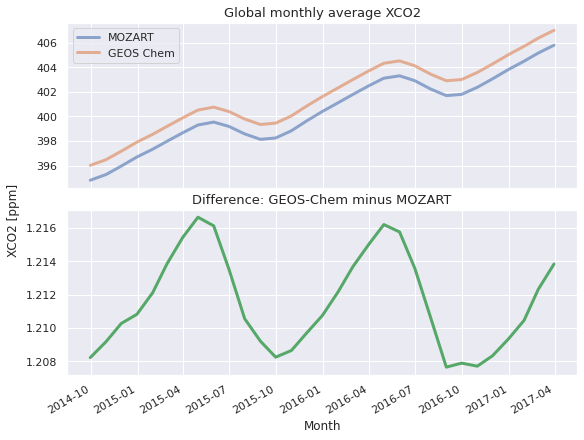

In [8]:
fig, axes = plt.subplots(2, 1, figsize=[8, 6], sharex=True, constrained_layout=True)

da_mozart_xco2_avg.plot(ax=axes[0], linewidth=3, alpha=0.6, label="MOZART")
da_geoschem_xco2_avg.plot(ax=axes[0], linewidth=3, alpha=0.6, label="GEOS Chem")
axes[0].set_title("Global monthly average XCO2", fontsize=13)
axes[0].set_xlabel(None)
axes[0].legend()

da_xco2_avg_diff.plot(ax=axes[1], linewidth=3, color="#55a868")
axes[1].set_title("Difference: GEOS-Chem minus MOZART", fontsize=13)
axes[1].set_xlabel("Month", fontsize=12)

fig.supylabel("XCO2 [ppm]", fontsize=12)
fig.savefig("../figures/timeseries_global_monthly_average_xco2.png", dpi=200);